The dataset consists of 1440 files (both songs and speech): 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male). 

Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Source: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Importing the libraries**

In [8]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# **2. Reading the data**

In [3]:
path_ravdess = 'drive/MyDrive/ravdess/'
path_tess = 'drive/MyDrive/tess/'
path_cremad = 'drive/MyDrive/crema-d/'
path_savee = 'drive/MyDrive/savee/'

###**Reading RAVDESS dataset**

In [4]:
ravdess_directory_list = os.listdir(path_ravdess)
#ravdess_directory_list.sort()

gender = []
ravdess_emotion = []
ravdess_path = []
for i in ravdess_directory_list:
    fname = os.listdir(path_ravdess + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        ravdess_emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        ravdess_path.append(path_ravdess + i + '/' + f)

        
emotions = pd.DataFrame(ravdess_emotion)
emotions = emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})

emotions_gender = pd.concat([pd.DataFrame(gender), emotions],axis=1)
emotions_gender.columns = ['gender', 'emotion']

emotions_gender['label'] = emotions_gender.gender + '_' + emotions_gender.emotion

ravdess_df = pd.concat([emotions_gender, pd.DataFrame(ravdess_path, columns = ['path'])],axis=1)
ravdess_df = ravdess_df.drop(['gender', 'emotion'], axis=1)
ravdess_df['source'] = 'RAVDESS'  
print(ravdess_df.label.value_counts())
ravdess_df

male_neutral       144
female_neutral     144
male_surprise       96
male_happy          96
male_angry          96
male_sad            96
female_angry        96
female_surprise     96
male_disgust        96
female_happy        96
female_fear         96
female_disgust      96
male_fear           96
female_sad          96
Name: label, dtype: int64


,label,path,source
0,male_sad,drive/MyDrive/ravdess/Actor_03/03-01-04-01-02-...,RAVDESS
1,male_neutral,drive/MyDrive/ravdess/Actor_03/03-01-01-01-01-...,RAVDESS
2,male_neutral,drive/MyDrive/ravdess/Actor_03/03-01-02-02-02-...,RAVDESS
3,male_happy,drive/MyDrive/ravdess/Actor_03/03-01-03-02-02-...,RAVDESS
4,male_happy,drive/MyDrive/ravdess/Actor_03/03-01-03-02-01-...,RAVDESS
...,...,...,...
1435,female_surprise,drive/MyDrive/ravdess/Actor_22/03-01-08-02-01-...,RAVDESS
1436,female_surprise,drive/MyDrive/ravdess/Actor_22/03-01-08-02-02-...,RAVDESS
1437,female_surprise,drive/MyDrive/ravdess/Actor_22/03-01-08-01-02-...,RAVDESS
1438,female_surprise,drive/MyDrive/ravdess/Actor_22/03-01-08-01-01-...,RAVDESS


###**Reading TESS dataset**

In [5]:
tess_directory_list = os.listdir(path_tess)

tess_emotion = []
tess_path = []

for i in tess_directory_list:
    fname = os.listdir(path_tess + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            tess_emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            tess_emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            tess_emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            tess_emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            tess_emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            tess_emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            tess_emotion.append('female_sad')
        else:
            tess_emotion.append('Unknown')
        tess_path.append(path_tess + i + "/" + f)

emotions = pd.DataFrame(tess_emotion, columns = ['label'])
paths = pd.DataFrame(tess_path, columns = ['path'])

tess_df = pd.concat([emotions, paths], axis=1)
tess_df['source'] = 'TESS'
tess_df.label.value_counts()
tess_df

,label,path,source
0,female_disgust,drive/MyDrive/tess/OAF_disgust/OAF_good_disgus...,TESS
1,female_disgust,drive/MyDrive/tess/OAF_disgust/OAF_beg_disgust...,TESS
2,female_disgust,drive/MyDrive/tess/OAF_disgust/OAF_gin_disgust...,TESS
3,female_disgust,drive/MyDrive/tess/OAF_disgust/OAF_dab_disgust...,TESS
4,female_disgust,drive/MyDrive/tess/OAF_disgust/OAF_five_disgus...,TESS
...,...,...,...
2795,female_surprise,drive/MyDrive/tess/YAF_pleasant_surprised/YAF_...,TESS
2796,female_surprise,drive/MyDrive/tess/YAF_pleasant_surprised/YAF_...,TESS
2797,female_surprise,drive/MyDrive/tess/YAF_pleasant_surprised/YAF_...,TESS
2798,female_surprise,drive/MyDrive/tess/YAF_pleasant_surprised/YAF_...,TESS


###**Reading CREMA-D dataset**

In [6]:
cremad_directory_list = os.listdir(path_cremad)

gender = []
cremad_emotion = []
cremad_path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for track in cremad_directory_list: 
    part = track.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        cremad_emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        cremad_emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        cremad_emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        cremad_emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        cremad_emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        cremad_emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        cremad_emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        cremad_emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        cremad_emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        cremad_emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        cremad_emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        cremad_emotion.append('female_neutral')
    else:
        cremad_emotion.append('Unknown')
    cremad_path.append(path_cremad + track)
    
emotions = pd.DataFrame(cremad_emotion, columns = ['label'])
paths = pd.DataFrame(cremad_path, columns = ['path'])


cremad_df = pd.concat([emotions, paths], axis=1)
cremad_df['source'] = 'CREMA'
print(cremad_df.label.value_counts())
cremad_df

male_angry        671
male_disgust      671
male_sad          671
male_fear         671
male_happy        671
female_disgust    600
female_angry      600
female_happy      600
female_fear       600
female_sad        600
male_neutral      575
female_neutral    512
Name: label, dtype: int64


,label,path,source
0,female_disgust,drive/MyDrive/crema-d/1079_TSI_DIS_XX.wav,CREMA
1,male_disgust,drive/MyDrive/crema-d/1080_DFA_DIS_XX.wav,CREMA
2,female_disgust,drive/MyDrive/crema-d/1079_WSI_DIS_XX.wav,CREMA
3,female_neutral,drive/MyDrive/crema-d/1079_WSI_NEU_XX.wav,CREMA
4,female_sad,drive/MyDrive/crema-d/1079_TSI_SAD_XX.wav,CREMA
...,...,...,...
7437,female_happy,drive/MyDrive/crema-d/1006_IEO_HAP_MD.wav,CREMA
7438,female_fear,drive/MyDrive/crema-d/1006_IEO_FEA_MD.wav,CREMA
7439,female_angry,drive/MyDrive/crema-d/1006_ITS_ANG_XX.wav,CREMA
7440,female_sad,drive/MyDrive/crema-d/1006_ITS_SAD_XX.wav,CREMA


###**Reading SAVEE dataset**

In [7]:
savee_directory_list = os.listdir(path_savee)

savee_emotion = []
savee_path = []
for dir in savee_directory_list:
    # there are 4 actors in the dataset, we need to extract the audiofiles for each of them
    actor = os.listdir(path_savee + dir)
    for file in actor:
        if file[0:1] == 'a':
            savee_emotion.append('male_angry')
        elif file[0:1] == 'd':
            savee_emotion.append('male_disgust')
        elif file[0:1] == 'f':
            savee_emotion.append('male_fear')
        elif file[0:1] == 'h':
            savee_emotion.append('male_happy')
        elif file[0:1] == 'n':
            savee_emotion.append('male_neutral')
        elif file[0:2] == 'sa':
            savee_emotion.append('male_sad')
        elif file[0:2] == 'su':
            savee_emotion.append('male_surprise')
        else:
            savee_emotion.append('male_error') 
        savee_path.append(path_savee + dir + '/' + file)
        

emotions = pd.DataFrame(savee_emotion, columns=['label'])
paths = pd.DataFrame(savee_path, columns=['path'])

savee_df = pd.concat([emotions, paths], axis=1)
savee_df['source'] = 'SAVEE'
print(savee_df.label.value_counts())
savee_df

male_neutral     120
male_surprise     60
male_fear         60
male_sad          60
male_happy        60
male_angry        60
male_disgust      60
Name: label, dtype: int64


,label,path,source
0,male_angry,drive/MyDrive/savee/JK/a08.wav,SAVEE
1,male_angry,drive/MyDrive/savee/JK/a13.wav,SAVEE
2,male_angry,drive/MyDrive/savee/JK/a05.wav,SAVEE
3,male_angry,drive/MyDrive/savee/JK/a11.wav,SAVEE
4,male_angry,drive/MyDrive/savee/JK/a10.wav,SAVEE
...,...,...,...
475,male_surprise,drive/MyDrive/savee/DC/su12.wav,SAVEE
476,male_surprise,drive/MyDrive/savee/DC/su04.wav,SAVEE
477,male_surprise,drive/MyDrive/savee/DC/su08.wav,SAVEE
478,male_surprise,drive/MyDrive/savee/DC/su15.wav,SAVEE


###**Combining all the data**

In [8]:
df = pd.concat([savee_df, ravdess_df, tess_df, cremad_df], axis=0)
print(df.label.value_counts())
df.to_csv("Data_path.csv",index=False)
df.head()

female_disgust     1096
female_fear        1096
female_sad         1096
female_angry       1096
female_happy       1096
female_neutral     1056
male_neutral        839
male_sad            827
male_fear           827
male_angry          827
male_disgust        827
male_happy          827
female_surprise     496
male_surprise       156
Name: label, dtype: int64


,label,path,source
0,male_angry,drive/MyDrive/savee/JK/a08.wav,SAVEE
1,male_angry,drive/MyDrive/savee/JK/a13.wav,SAVEE
2,male_angry,drive/MyDrive/savee/JK/a05.wav,SAVEE
3,male_angry,drive/MyDrive/savee/JK/a11.wav,SAVEE
4,male_angry,drive/MyDrive/savee/JK/a10.wav,SAVEE


# **3. Exploratory data analysis (EDA)**

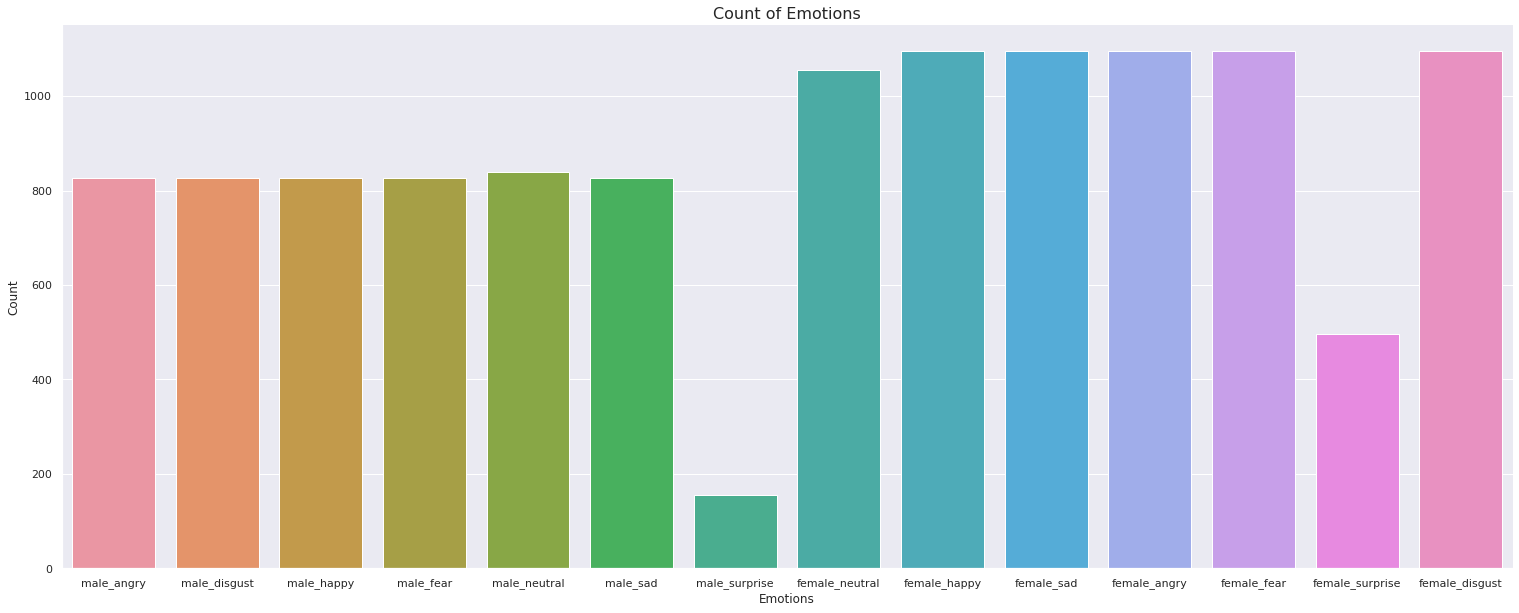

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=df.label)
sns.set(rc={'figure.figsize':(26, 10)})
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show();

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

###**RAVDESS dataset: comparison of male and female in terms of the emotion ('sad')**

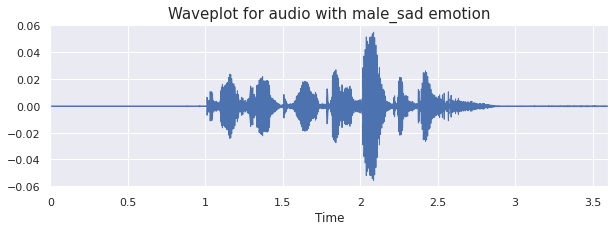

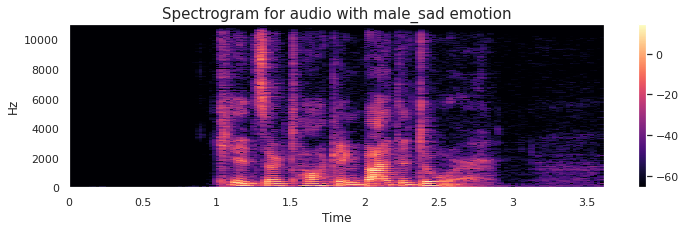

In [11]:
emotion = 'male_sad'
path = np.array(df.path[(df.label==emotion) & (df.source=='RAVDESS')])[6]

data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

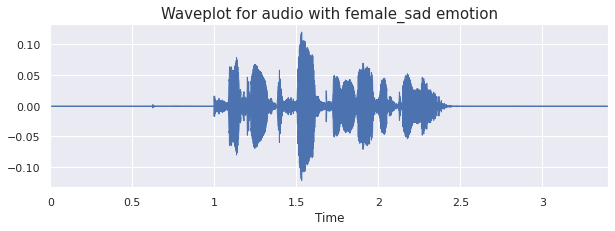

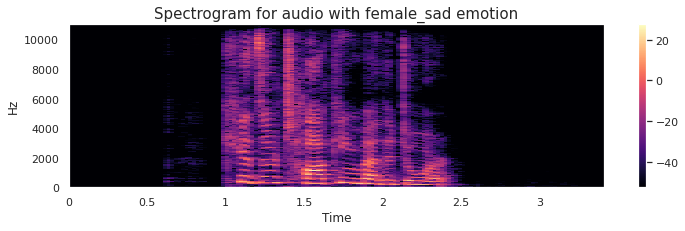

In [12]:
emotion = 'female_sad'
path = np.array(df.path[(df.label==emotion) & (df.source=='RAVDESS')])[1]

data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

###**CREMA-D dataset: comparison of male and female in terms of the emotion ('sad')**

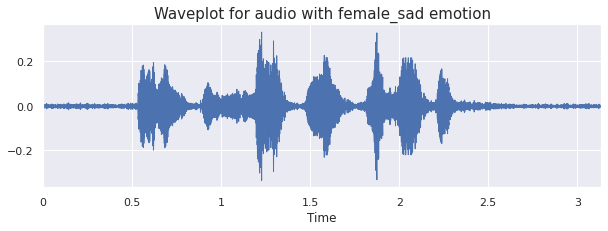

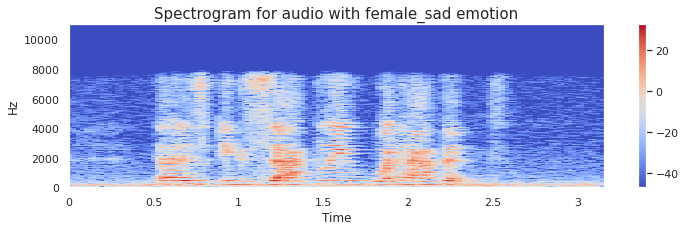

In [159]:
emotion = 'female_sad'
path = np.array(df.path[(df.label==emotion) & (df.source=='CREMA')])[1]

data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

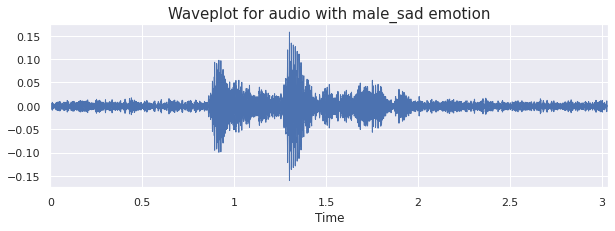

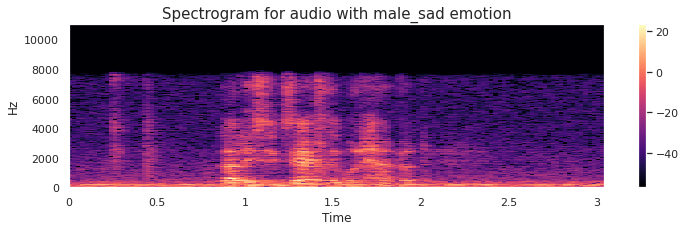

In [160]:
emotion = 'male_sad'
path = np.array(df.path[(df.label==emotion) & (df.source=='CREMA')])[1]

data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **4. Augmentation of data**

In [14]:
def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2 *(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, 
                                       n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    dyn_change = np.random.uniform(low=-0.5, high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0,len(data)), data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [32]:
# taking any example and checking for techniques
path = np.array(df.path)[1000]
print('Emotion for the example:', np.array(df.label)[1000])
data, sample_rate = librosa.load(path)

Emotion for the example: female_fear


### **Original audio**

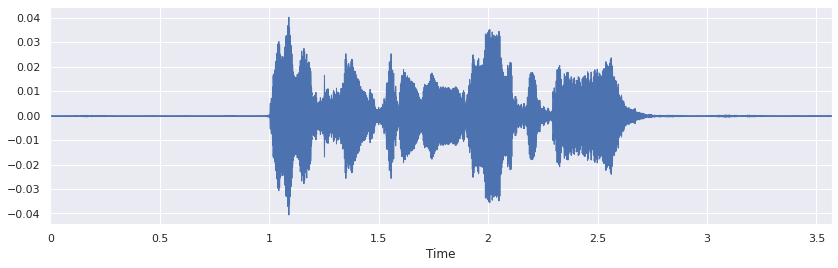

In [25]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### **Noise**

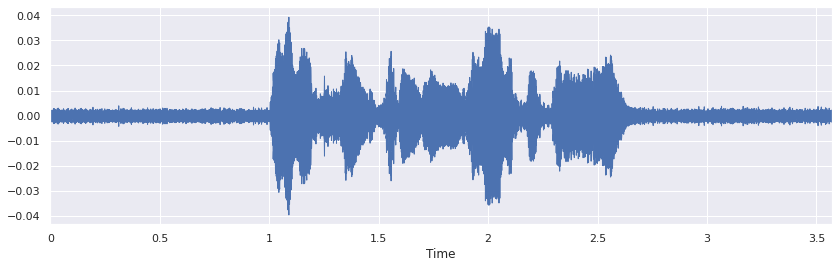

In [26]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Stretch**

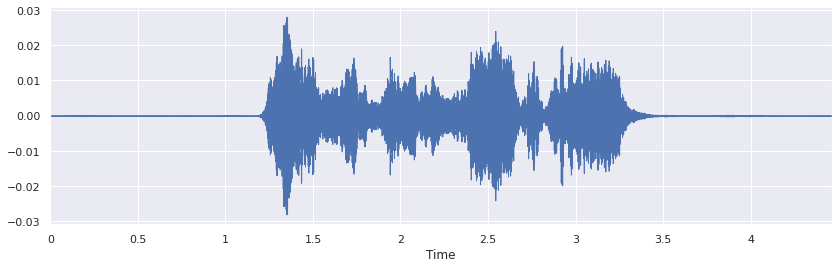

In [27]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Shift**

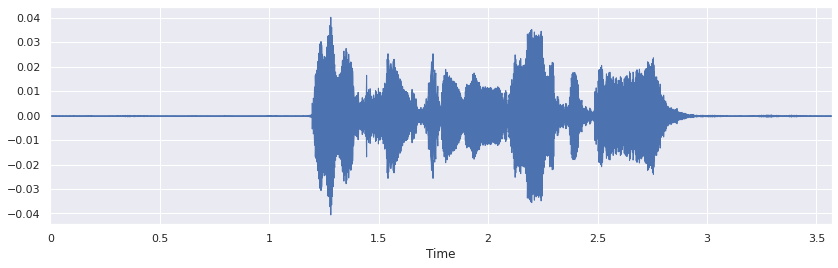

In [33]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Pitch**

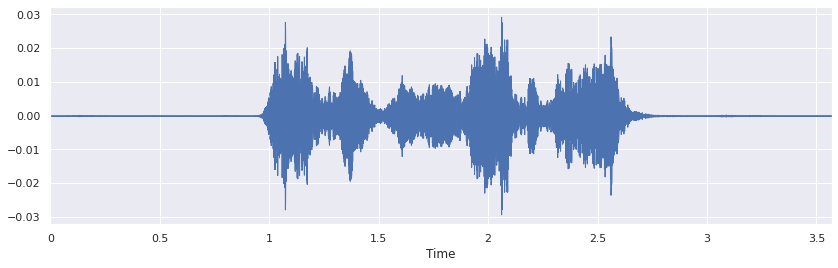

In [34]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Dynamic change**

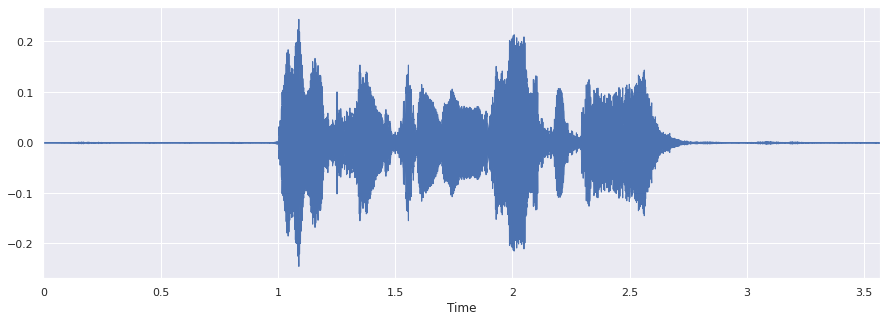

In [36]:
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

###**Speed and pitch**

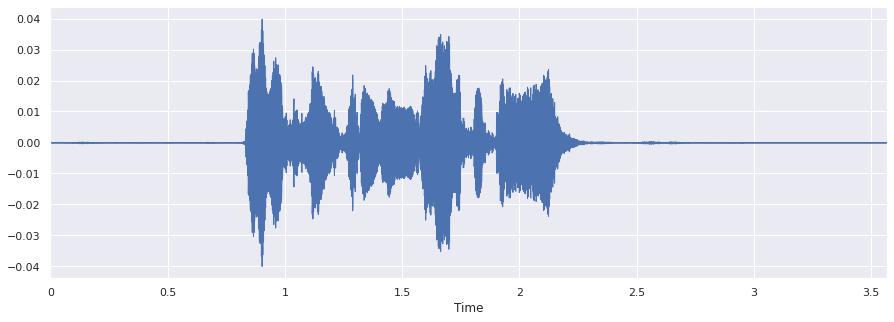

In [37]:
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

# **5. Preparing data for the model**

In [38]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with dynamic change
    data_dyn_change = dyn_change(data)
    res4 = extract_features(data_dyn_change)
    result = np.vstack((result, res4)) # stacking vertically
    
    # data with speedNpitch
    data_speedNpitch = speedNpitch(data)
    res5 = extract_features(data_speedNpitch)
    result = np.vstack((result, res5)) # stacking vertically

    return result

In [40]:
x, Y = [], []

for path, emotion in zip(df.path, df.label):
    feature = get_features(path)
    for ele in feature:
        x.append(ele)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [41]:
len(x), len(Y), df.path.shape

(60810, 60810, (12162,))

In [43]:
df = pd.DataFrame(x)
df['labels'] = Y
df.to_csv('features.csv', index=False)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.100703,0.509700,0.456025,0.446354,0.477928,0.532280,0.558244,0.507591,0.449210,0.494191,0.492117,0.506494,0.533566,-160.962341,94.651115,-11.304188,45.292877,-16.986473,-3.420444,-24.070143,-4.346818,-15.169671,-7.007307,-5.197854,-6.737709,-4.312316,-2.467457,-0.460825,-3.012980,-2.472142,-2.478859,-4.390736,-6.717069,0.351735,3.764557,0.404794,0.232812,1.936879,19.898417,30.844809,...,0.285311,0.201387,0.171833,0.172932,0.117505,0.153476,0.203095,0.184637,0.166785,0.175324,0.167285,0.194206,0.180489,0.161429,0.191505,0.178128,0.114580,0.084310,0.055819,0.027641,0.021724,0.018516,0.016580,0.015458,0.010829,0.007875,0.005898,0.003837,0.001806,0.001134,0.000672,0.000510,0.000378,0.000270,0.000198,0.000165,0.000129,0.000037,0.000003,male_angry
1,0.190823,0.641455,0.599919,0.558523,0.581173,0.606514,0.599201,0.561116,0.516213,0.551836,0.570831,0.589649,0.646299,-47.424754,45.068530,6.238729,12.281039,0.233776,-7.675084,-12.083078,-11.251211,-10.383692,-7.211139,-1.384766,-4.116535,-3.698412,-1.513494,-1.307679,-1.607432,-3.403840,-2.288471,-2.683694,-4.245681,0.356948,3.855589,0.497418,0.332888,2.045469,20.063200,30.893474,...,0.388211,0.300184,0.262152,0.271399,0.212725,0.264045,0.302207,0.295920,0.265503,0.279579,0.260394,0.289292,0.286161,0.250943,0.282212,0.276446,0.208775,0.181355,0.145310,0.126328,0.127643,0.121873,0.103332,0.118277,0.111496,0.107334,0.104110,0.101607,0.094485,0.100603,0.102334,0.101170,0.098504,0.102386,0.106024,0.102534,0.098170,0.092177,0.096939,male_angry
2,0.126848,0.478778,0.528043,0.584549,0.530730,0.492109,0.447483,0.453395,0.485027,0.522360,0.487435,0.443541,0.486022,-191.532873,83.353086,-9.908678,26.686290,-27.885167,-10.909955,-26.828924,-5.698312,-17.393203,0.561342,-9.733752,-3.705497,-3.485998,-1.566216,-6.552417,-5.488643,-6.970551,-5.652267,-7.928013,-1.588388,0.168229,1.627816,0.184367,0.043777,0.050786,0.290000,2.950188,...,0.116840,0.097809,0.061517,0.075625,0.068564,0.051444,0.037916,0.046118,0.032697,0.039011,0.020853,0.028138,0.036662,0.031499,0.034746,0.033424,0.028846,0.046468,0.040668,0.030892,0.040660,0.033026,0.022330,0.017298,0.010706,0.004975,0.003756,0.003732,0.002908,0.002764,0.002284,0.001581,0.001114,0.000815,0.000391,0.000225,0.000097,0.000024,0.000002,male_angry
3,0.100703,0.509700,0.456025,0.446354,0.477928,0.532280,0.558244,0.507591,0.449210,0.494190,0.492117,0.506494,0.533566,20.704302,94.651108,-11.304186,45.292873,-16.986471,-3.420447,-24.070141,-4.346820,-15.169670,-7.007308,-5.197853,-6.737710,-4.312317,-2.467458,-0.460825,-3.012980,-2.472143,-2.478859,-4.390736,-6.717069,2.233964,151.857224,16.328863,9.391334,78.131111,802.675659,1244.238770,...,11.509055,8.123680,6.931502,6.975837,4.739992,6.191036,8.192595,7.448007,6.727880,7.072323,6.748038,7.833999,7.280693,6.511815,7.725051,7.185456,4.621996,3.400969,2.251655,1.115018,0.876308,0.746895,0.668819,0.623546,0.436845,0.317681,0.237922,0.154762,0.072847,0.045741,0.027097,0.020587,0.015251,0.010872,0.007970,0.006648,0.005210,0.001496,0.000107,male_angry
4,0.092068,0.343135,0.384583,0.369049,0.398426,0.432806,0.399580,0.360596,0.349566,0.367986,0.398094,0.415690,0.374476,-211.114563,64.274483,-1.098529,11.573860,-24.146467,-11.459289,-13.422413,-5.008808,-8.482637,-0.264757,-7.266983,-0.569748,-4.075814,-4.500935,-6.145898,-3.500515,-4.451816,-1.849255,1.323312,1.827382,0.269477,2.921667,0.412107,0.160749,0.116360,0.269494,3.325446,...,0.529328,0.343513,0.250252,0.221021,0.235538,0.242236,0.233526,0.185665,0.154606,0.202779,0.116509,0.126251,0.098093,0.075414,0.079074,0.051954,0.059751,0.079686,0.080036,0.065846,0.069587,0.068162,0.067803,0.071040,0.061024,0.063882,0.066062,0.043451,0.029653,0.019418,0.010500,0.006801,0.005603,0.004757,0.00

In [5]:
df = pd.read_csv('features.csv')

In [6]:
x = df.iloc[: ,:-1].values
Y = df['labels'].values

In [9]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [10]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45607, 162), (45607, 14), (15203, 162), (15203, 14))

In [11]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45607, 162), (45607, 14), (15203, 162), (15203, 14))

In [12]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45607, 162, 1), (45607, 14), (15203, 162, 1), (15203, 14))

# **6. Building the model**

In [13]:
from tensorflow.keras import optimizers

model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), #'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          2304      
                                                                 
 activation (Activation)     (None, 162, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 162, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 162, 256)          0         
                                                                 
 dropout (Dropout)           (None, 162, 256)          0         
                                                        

In [15]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/10
2851/2851 [==============================] - 943s 331ms/step - loss: 1.2656 - accuracy: 0.5339 - val_loss: 1.3628 - val_accuracy: 0.5242 - lr: 1.0000e-04
Epoch 2/10
2851/2851 [==============================] - 859s 301ms/step - loss: 1.2203 - accuracy: 0.5480 - val_loss: 1.4406 - val_accuracy: 0.5066 - lr: 1.0000e-04
Epoch 3/10
2851/2851 [==============================] - 907s 318ms/step - loss: 1.1819 - accuracy: 0.5631 - val_loss: 1.3690 - val_accuracy: 0.5315 - lr: 1.0000e-04
Epoch 4/10
2851/2851 [==============================] - 897s 315ms/step - loss: 1.1471 - accuracy: 0.5714 - val_loss: 1.3386 - val_accuracy: 0.5425 - lr: 1.0000e-04
Epoch 5/10
2851/2851 [==============================] - 897s 315ms/step - loss: 1.1143 - accuracy: 0.5855 - val_loss: 1.2857 - val_accuracy: 0.5384 - lr: 1.0000e-04
Epoch 6/10
2851/2851 [==============================] - 871s 306ms/step - loss: 1.0841 - accuracy: 0.5999 - val_loss: 1.2858 - val_accuracy: 0.5513 - lr: 1.0000e-04
Epoch 7/10

476/476 [==============================] - 54s 113ms/step - loss: 1.1700 - accuracy: 0.5940
Accuracy of our model on test data :  59.39617156982422 %


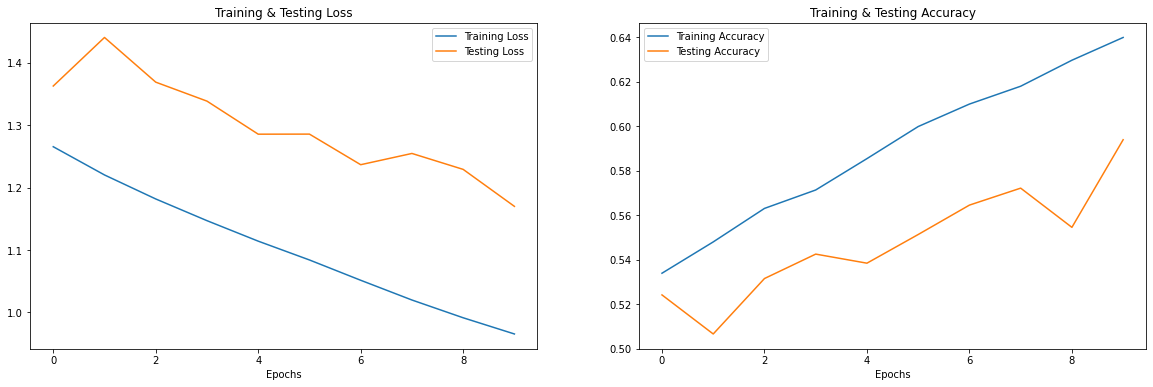

In [17]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# **7. Testing of model**

In [18]:
# predicting on test data
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,female_surprise,female_surprise
1,female_angry,female_angry
2,female_neutral,female_neutral
3,female_angry,female_happy
4,male_disgust,male_happy
5,male_sad,male_disgust
6,female_disgust,female_neutral
7,female_neutral,female_neutral
8,female_fear,female_fear
9,female_angry,female_happy


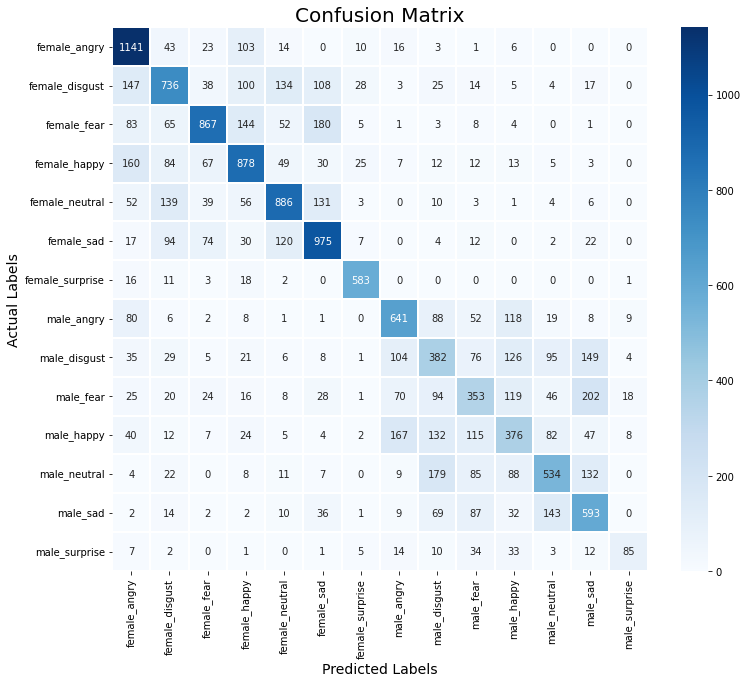

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.63      0.84      0.72      1360
 female_disgust       0.58      0.54      0.56      1359
    female_fear       0.75      0.61      0.68      1413
   female_happy       0.62      0.65      0.64      1345
 female_neutral       0.68      0.67      0.67      1330
     female_sad       0.65      0.72      0.68      1357
female_surprise       0.87      0.92      0.89       634
     male_angry       0.62      0.62      0.62      1033
   male_disgust       0.38      0.37      0.37      1041
      male_fear       0.41      0.34      0.38      1024
     male_happy       0.41      0.37      0.39      1021
   male_neutral       0.57      0.49      0.53      1079
       male_sad       0.50      0.59      0.54      1000
  male_surprise       0.68      0.41      0.51       207

       accuracy                           0.59     15203
      macro avg       0.60      0.58      0.58     15203
   weighted avg       0.59   

# **8. Saving the model**

In [22]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://ca1aecbf-a859-4ba9-bde5-dc9813307ff1/assets
